In [1]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import autograd.numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA
from pyblas.level1 import dnrm2

sys.path.insert(0, os.path.join(".."))
%load_ext autoreload
%autoreload 2

In [2]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut

# MDP

In [3]:
sys.path.insert(0, os.path.join("..", "tdlearn"))

In [4]:
sys.path.insert(0, os.path.join("..", "tdlearn", "util"))

In [5]:
# repo from https://github.com/chrodan/tdlearn
from tdlearn import examples
from tdlearn import features
from tdlearn import policies

In [6]:
n = 400 # |S|
n_a = 10
n_feat = 200 # d
mdp = examples.RandomMDP(n, n_a)
phi = features.lin_random(n_feat, n, constant=True)
gamma = .95
np.random.seed(3)
beh_pol = policies.Discrete(np.random.rand(n, n_a))
tar_pol = policies.Discrete(np.random.rand(n, n_a))

In [7]:
from task import LinearDiscreteValuePredictionTask

task = LinearDiscreteValuePredictionTask(mdp, gamma, phi, np.zeros(phi.dim),
                                         policy=beh_pol, target_policy=tar_pol)

In [8]:
Phi = task.Phi

### Check the equal methods of multidim dot

In [ ]:
_C = np.zeros((n_feat, n_feat))
for s in range(n):
    _C += Phi[s].T.dot(Phi[s])

In [ ]:
_C

array([[132.3901114 ,  97.76274183, 102.33712169, ..., 101.92788541,
         97.90852101, 198.62850564],
       [ 97.76274183, 133.84740882, 105.41928405, ..., 103.89166623,
        101.36922797, 199.80451165],
       [102.33712169, 105.41928405, 140.99246525, ..., 106.10621796,
        107.04401561, 207.82468526],
       ...,
       [101.92788541, 103.89166623, 106.10621796, ..., 138.4972571 ,
        103.59722151, 203.98860115],
       [ 97.90852101, 101.36922797, 107.04401561, ..., 103.59722151,
        138.57030077, 204.7450469 ],
       [198.62850564, 199.80451165, 207.82468526, ..., 203.98860115,
        204.7450469 , 400.        ]])

In [ ]:
C = np.tensordot(Phi[:, None, :], Phi[..., None], axes=([0,1], [0,2]))

In [ ]:
np.isclose(C,_C).all()

True

### Experiment setting

In [9]:
_states, _actions, _n_states, _rewards = [], [], [], []
N = 20000
for s, a, _s, r in task.mdp.sample_transition(max_n=N, policy=beh_pol, seed=None,
                                              with_restart=True, s_start=None):
    _states.append(s)
    _actions.append(a)
    _n_states.append(_s)
    _rewards.append(r)

In [10]:
C = np.tensordot(Phi[_states, None, :], Phi[_states, :, None], axes=([0,1], [0,2]))

In [11]:
b = np.asarray(np.array(_rewards).dot(Phi[_states, :]))

In [12]:
B = C - gamma*np.tensordot(Phi[_states, None, :], 
                           Phi[np.hstack([_states[1:], _states[-1]]), :, None], axes=([0,1], [0,2]))

In [41]:
import lib.utils as ut


class RL_problem(pr.BaseSaddle):
    def __init__(self, B, C, b, rho=1.):
        L_xy = 1
        mu_xy = 0.25
        mu_yx = 0.25
        A = -B
        super().__init__(A=A)
        self.A = A
        spectrum = LA.eig(self.A.T.dot(self.A))[0]
        self.L_xy = spectrum.real.max()**.5
        self.mu_yx = np.abs(spectrum).min()**.5 
        self.mu_xy = np.abs(LA.eig(self.A.dot(self.A.T))[0]).min()**.5
        self.C = C
        self.C_inv = LA.inv(self.C)
        self.b = b
        n = self.A.shape[0]
        
        self.rho = rho
        self.f = lambda x: self.rho*0.5*x.transpose() @ x
        self.g = lambda y:  0.5*y.transpose() @ self.C @ y - self.b.transpose().squeeze() @ y
        self.L_x = self.rho
        self.mu_x = self.rho
        
        spectrum = LA.eig(self.C)[0]
        self.L_y = spectrum.max()
        self.mu_y = spectrum.real.min() 
        if self.rho == 0:
            self.yopt = LA.solve(self.A.transpose(), np.zeros((n, 1))) 
            self.xopt = LA.solve(self.A, self.C.dot(self.yopt) - self.b)
        else:
            self.yopt = LA.solve(self.C + 1/self.rho*self.A @ self.A.T, self.b) 
            self.xopt =  -1/self.rho * self.A.T.dot(self.yopt)
            
        self.constraint=False   
        self.grad_f = grad(self.f)
        self.grad_g = grad(self.g)  
        self.d2fdxdx = grad(self.grad_f)
        self.F = lambda x, y: self.f(x) + y.T @ self.A @ x - self.g(y)
        self.dFdx = grad(self.F)
        self.dFdy = grad(self.F, 1)
        self._proj_x = None
        self._proj_y = None
        
    def MSPBE_loss(self, x, y):
        return 0.5 * ((self.A.dot(x) - self.b.squeeze()).T.dot(self.C_inv).dot(self.A.dot(x) - self.b.squeeze()))
    
    def primal_func(self, x, y=None):
        """
        Computes the function value
        f_max(x) = \max_y F(x, y)
  
        F(x, y) = f(x) + <y, Ax> - g(y)
        f(x) = rho 0.5 <x, x>
        g(y) = -0.5 <y, Cy> + <b, y>
        Args:
            x: np.array([dx])
        Returns:
            f_max(x): real function value
        """
        matrix = self.C
        vector = self.A.dot(x) + self.b.squeeze()

        try:
            y_max = scipy.linalg.solve(matrix, vector, check_finite=True, assume_a='sym')
        except scipy.linalg.LinAlgError:
            y_max = scipy.linalg.lstsq(matrix, vector, check_finite=True)[0]

        return self.F(x, y_max)

    def dual_func(self, y, x=None, func_lb=None):
        """
        Computes the function value
        g_min(y) = \min_x F(x, y)
  
        F(x, y) = f(x) + <y, Ax> - g(y)
        f(x) = 0.5 rho <x, x>
        g(y) = -0.5 <y, Cy> + <b, y>
        Args:
            y: np.array([dy])
        Returns:
            h_min(y): real function value
        """
        matrix = self.rho * np.eye(x.shape[0])
        vector = -self.A.T.dot(y)
        try:
            x_min = scipy.linalg.solve(matrix, vector, check_finite=True, assume_a='sym')
        except scipy.linalg.LinAlgError:
            x_min = scipy.linalg.lstsq(matrix, vector, check_finite=True)[0]
          
        return self.F(x_min, y)

In [56]:
A=-B
RHO = LA.svd(A.T.dot(LA.inv(C)).dot(A))[1].max()
# RHO = 1.
problem_RL = RL_problem(B=B,C=C, b=b.T, rho=RHO)
L = max(problem_RL.L_x, problem_RL.L_y, problem_RL.L_xy)
params = {"apdg": None,
          "lpd": None,
          'altgd': {"lr": 1 / (2*L)},
          'simgd': {"lr": 1 / (2*L)},
          # 'avg': {"lr": 1 / (2*L)},
          'eg': {"lr": 1 / (2*L)},
          'omd': {"lr": 1 / (2*L)},
          'AA': {"lr": 1 / (2*L), 
                 "k": 10,
                 "type2": True,
                 "reg": 1e-10,
                 "gamma": 1e-26
                }
         }
 # {'adam':0.01,'fr':0.05,}

x0 = np.ones(n_feat, )
y0 = np.ones(n_feat, )
type2=True
iteration = 10000
k =  100
methods_dict = ut.main(problem_RL, iteration, x0.copy(), y0.copy(), params)

LPD: 100%|██████████████████████████████████████████████████████████████████████| 10000/10000 [01:12<00:00, 138.16it/s]


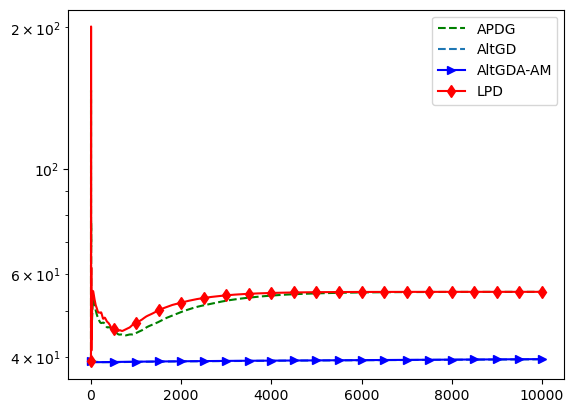

In [58]:
%matplotlib inline
plot_interval = 1
markevery=500
for method in methods_dict:
    if method not in ["EG", "OMD", "SimGD"]:
        plt.semilogy(np.arange(0, iteration+plot_interval, plot_interval),
                     methods_dict[method]["loss_hist"][::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.legend()

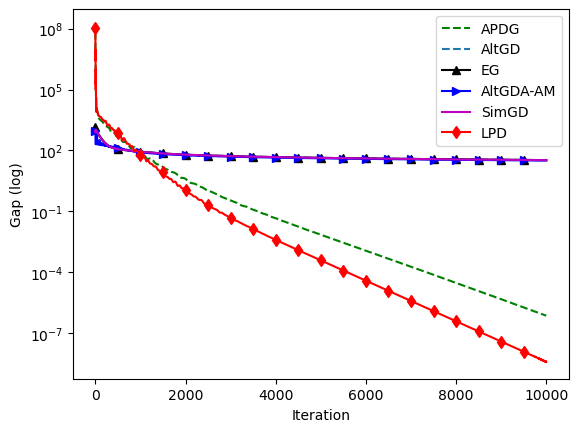

In [60]:
plot_interval = 1
markevery=500
for method in methods_dict:
    if method not in ["OMD"]:
        _gap =methods_dict[method]["class"].all_metrics["gap"]
        plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
                     _gap[::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("Gap (log)")
plt.legend()

In [349]:
ut.display_constants(problem_RL)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [356]:
problem_RL.MSPBE_loss(methods_dict["APDG"]["class"].x,
                      methods_dict["APDG"]["class"].y
                     )

3892.9327651479434

# MountainCar
Data is taken from https://github.com/tkkiran/LiftedPrimalDual/tree/main/mountaincar_data

In [357]:
import pandas as pd

In [358]:
state = pd.read_csv(os.path.join("..", "data", 'mountaincar_data', 'state.csv'),
                    delimiter=',', header=None).to_numpy().T#[:, :5000]
reward = pd.read_csv(os.path.join("..", "data", 'mountaincar_data', 'reward.csv'),
                     delimiter=',', header=None).to_numpy()#[:5000, :]
next_state = pd.read_csv(os.path.join("..", "data", 'mountaincar_data', 'nextstate.csv'),
                         delimiter=',', header=None).to_numpy().T#[:, :5000]

In [359]:
GAMMA = 0.95
Phi = state
Phi_next = next_state

Phi_gamma_phi_next = Phi - GAMMA * Phi_next
reward_phi = Phi.dot(reward)

In [360]:
n = Phi.shape[-1]
A = Phi.dot(Phi_gamma_phi_next.T)/n
b = reward_phi/n
C = Phi.dot(Phi.T)/n

In [364]:
LA.matrix_rank(C)

204

In [361]:
d = 300

rho = 1.0
B = rho*np.eye(C.shape[0])

In [363]:
A=-B
n_feat = d

problem_RL_2 = RL_problem(B=B,C=C, b=b.T, rho=rho)
L = max(problem_RL_2.L_x, problem_RL_2.L_y, problem_RL_2.L_xy)
params = {"apdg": None,
          "lpd": None,
          'altgd': {"lr": 1 / (2*L)},
          'simgd': {"lr": 1 / (2*L)},
          # 'avg': {"lr": 1 / (2*L)},
          'eg': {"lr": 1 / (2*L)},
          'omd': {"lr": 1 / (2*L)},
          'AA': {"lr": 1 / (2*L), 
                 "k": 10,
                 "type2": True,
                 "reg": 1e-10,
                 "gamma": 1e-26
                }
         }
 # {'adam':0.01,'fr':0.05,}

x0 = np.ones(n_feat, )
y0 = np.ones(n_feat, )
type2=True
iteration = 10000
k =  100
methods_dict = ut.main(problem_RL_2, iteration, x0.copy(), y0.copy(), params)

LinAlgError: Singular matrix